In [2]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(scales)
if (!require(extrafont)) install.packages("extrafont")
library(extrafont)

# 3. 폰트 로드
loadfonts()

In [47]:
cohort <- "GS" # UKB, GS

# Step 1. Load data

## Load slope test results

In [48]:
# 방법 1: paste0() 사용
frreg_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/", 
    cohort, 
    "/obj1/slope-test"
)

# .slope 파일 리스트 불러오기
files_list <- list.files(
    path = frreg_path, 
    pattern = "\\.slope$",  
    full.names = TRUE
) %>% 
    # .raw.slope 파일 제외
    .[!grepl("\\.raw\\.slope$", .)]

length(files_list)

[1] 24

In [49]:
# 모든 .slope 파일 읽고 원하는 형태로 가공하기
df_slope_test <- files_list %>%
    # 각 파일을 읽어서 리스트로 만들기
    map(function(file) {
        # 파일명에서 pheno 이름 추출 (첫번째 '.' 이전까지의 문자열)
        pheno <- basename(file) %>%
            strsplit("\\.") %>%
            .[[1]] %>%
            .[2]
        
        # 파일 읽기
        df <- fread(file)
        
        # slope와 intercept의 median 값 추출
        slope_val <- df[param == "slope", median]
        intercept_val <- df[param == "intercept", median]
        
        # significant 판단
        slope_lower <- df[param == "slope", `lower(2.5%)`]
        slope_upper <- df[param == "slope", `upper(97.5%)`]
        
        significant <- case_when(
            slope_lower > 1 ~ "Fast",
            slope_upper < 1 ~ "Slow",
            TRUE ~ "Similar"
        )
        
        # 데이터프레임 생성
        data.frame(
            pheno = pheno,
            slope = slope_val,
            intercept = intercept_val,
            significant = significant
        )
    }) %>%
    # 모든 데이터프레임 합치기
    bind_rows()

head(df_slope_test)

,pheno,slope,intercept,significant
,<chr>,<dbl>,<dbl>,<chr>
1,abpi,0.4934937,-3.0806875,Similar
2,avg_dia,0.5759438,-2.7393497,Similar
3,avg_hr,0.5010706,-2.5668180,Slow
4,avg_sys,0.7245335,-2.7345967,Similar
5,Creat_mgdl,0.6953570,-0.8745035,Slow
6,Creatinine,0.7379110,-0.7467509,Slow


## Load prediction results

In [50]:
frreg_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/", 
    cohort, 
    "/obj1/prediction"
)

# .slope 파일 리스트 불러오기
files_list <- list.files(
    path = frreg_path, 
    pattern = "\\.pred$",  
    full.names = TRUE
) %>% 
    # .raw.slope 파일 제외
    .[!grepl("\\.raw\\.pred$", .)]

length(files_list)

[1] 24

In [51]:
# 모든 .pred 파일 읽고 원하는 형태로 가공하기
df_prediction <- files_list %>%
    # 각 파일을 읽어서 리스트로 만들기
    map(function(file) {
        # 파일명에서 pheno 이름 추출 (첫번째 '.' 이전까지의 문자열)
        pheno <- basename(file) %>%
            strsplit("\\.") %>%
            .[[1]] %>%
            .[2]
        
        # 파일 읽기
        df <- fread(file)
        
        # 필요한 파라미터만 추출 (V(g), V(s), w)
        df_filtered <- df %>%
            filter(param %in% c("V(g)", "V(s)", "w"))
        
        # wide format으로 변환
        data.frame(
            pheno = pheno,
            # V(g) 관련 컬럼
            Vg_median = df_filtered[param == "V(g)", median],
            Vg_lower = df_filtered[param == "V(g)", `lower(2.5%)`],
            Vg_upper = df_filtered[param == "V(g)", `upper(97.5%)`],
            # V(s) 관련 컬럼
            Vs_median = df_filtered[param == "V(s)", median],
            Vs_lower = df_filtered[param == "V(s)", `lower(2.5%)`],
            Vs_upper = df_filtered[param == "V(s)", `upper(97.5%)`],
            # w 관련 컬럼
            w_median = df_filtered[param == "w", median],
            w_lower = df_filtered[param == "w", `lower(2.5%)`],
            w_upper = df_filtered[param == "w", `upper(97.5%)`]
        )
    }) %>%
    # 모든 데이터프레임 합치기
    bind_rows()

head(df_prediction)

,pheno,Vg_median,Vg_lower,Vg_upper,Vs_median,Vs_lower,Vs_upper,w_median,w_lower,w_upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,abpi,0.00000100,0.0000010,0.00000100,0.09758811,0.09650154,0.10509314,0.60,0.56475,0.60000
2,avg_dia,0.00000100,0.0000010,0.00000100,0.11180044,0.11098799,0.11264830,0.60,0.60000,0.60000
3,avg_hr,0.16009295,0.1577944,0.16213983,0.04190063,0.04103793,0.04284621,0.95,0.95000,0.95000
4,avg_sys,0.03038340,0.0000010,0.04259244,0.07963769,0.07364123,0.10559067,0.60,0.53000,0.60000
5,Creat_mgdl,0.01295814,0.0000010,0.47463158,0.33224475,0.10599901,0.35266653,0.63,0.60475,0.84000
6,Creatinine,0.00000100,0.0000010,0.47897392,0.35949658,0.12138215,0.37324869,0.59,0.57000,0.73625


In [52]:
# merg
# df_slope_test와 df_prediction을 pheno 기준으로 병합
df_merged <- df_slope_test %>%
    left_join(df_prediction, by = "pheno")

# 결과 확인
dim(df_merged)

[1] 24 13

# plot theme

In [53]:
# 공통 테마 함수 정의
get_nature_theme <- function() {
    theme_bw() +
        theme(
            # 전체적인 배경
            panel.background = element_rect(fill = NA, color = NA),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color = "black", fill = NA, size = 0.6),  # size로 선 굵기 조절
            
            # panel.border = element_blank(),  
            
            # 축 설정
            # axis.line.x.top = element_line(color = "black", size = 0.3),  
            # axis.line.y.right = element_line(color = "black", size = 0.3),  
            # axis.line.x.bottom = element_line(color = "black", size = 0.3),  
            # axis.line.y.left = element_line(color = "black", size = 0.3),    
            axis.text = element_text(size = 6.5, color = "black"),
            axis.title = element_text(size = 7.5, color = "black"),
            axis.ticks = element_line(size = 0.3),
            axis.ticks.length = unit(0.8, "mm"),
            
            # 메인 figure에 박스 추가
            # plot.background = element_rect(color = "black", fill = NA),
            
            # legend 박스 제거
            legend.box.background = element_blank(),  # 이전: element_rect(color = "black")
            
            # 범례 설정
            legend.margin = margin(1, 1, 1, 1, unit = "mm"),
            # legend.spacing.y = unit(0.1, "cm"),
            
            # 여백 설정
            # plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
            plot.margin = margin(1, 1, 1, 1, unit = "mm")
        )
}

# 공통 색상 정의
color_values <- c(
    "Fast" = "#E64B35",
    "Slow" = "#4DBBD5",
    "Similar" = "#7E7E7E"
)

# Step 2. Plot

In [54]:
for_plot <- df_merged %>%
    filter(Vg_lower > 1e-4 & Vs_lower > 1e-4)

# for_plot <- df_merged

# for_plot <- df_merged %>%
    # filter(Vg_lower > 1e-4)

# 필터링 결과 확인
dim(for_plot)

[1] 10 13

In [55]:
# CSV 파일로 저장
write.table(
    for_plot, 
    paste0("/data/jerrylee/pjt/BIGFAM.v.2.0/data/supple/", cohort, ".prediction.sigV.tsv"),
    row.names = FALSE,
    sep = '\t',
    quote = FALSE)


In [56]:
plot_variance <- function(data, figure_tag = NULL) {
    p <- ggplot(data, aes(x = Vg_median, y = Vs_median)) +
        geom_point(aes(fill = significant),
                  size = 3, 
                  alpha = 0.8,
                  shape = 21,
                  stroke = 0.3,
                  color = "grey50") +
        scale_fill_manual(
            values = color_values,
            guide = guide_legend(
                override.aes = list(
                    shape = 21,
                    color = "white",
                    size = 2.5
                ),
                name = "Decaying",
                keywidth = unit(0.5, "lines"),
                keyheight = unit(0.5, "lines")
            )
        ) +
        labs(
            x = "G.variance",
            y = "S.variance",
            fill = "Decaying"
        ) +
        scale_x_continuous(
            breaks = scales::pretty_breaks(),
            limits = c(0, 0.8)
        ) +
        scale_y_continuous(
            breaks = scales::pretty_breaks(),
            limits = c(0, 0.3)) +
        get_nature_theme() + 
        theme(
            legend.position = "right", #c(0.8, 0.5),  # x, y 위치 (0-1 사이 값)
            # legend.justification = c(0, 0.5),    # 좌측 상단 기준 정렬
            legend.box.margin = margin(0, 0, 0, 0, unit = "mm"),
            legend.spacing.x = unit(0, "mm"),  # figure와 legend 사이 간격
            # legend.box.background = element_rect(color = "black"),
            legend.background = element_rect(fill = NA, color = NA),
            legend.title = element_text(size = 7),
            legend.text = element_text(size = 7),      # 범례 텍스트 크기
            legend.key.size = unit(0.5, "lines"),
            legend.key.height = unit(0.5, "lines"),
            legend.key.width = unit(0.5, "lines"),
            plot.margin = margin(1, 0, 0, 0, "mm")

            # # legend.position = "top",
            # legend.position = c(0.9, 0.9),  # x, y 위치 (0-1 사이 값)
            # legend.justification = c(1, 1),    # 좌측 상단 기준 정렬
            # legend.title = element_blank(),
            # legend.box.background = element_rect(color = "black"),
            # legend.background = element_rect(fill = NA, color = NA),
        )
    
    if (!is.null(figure_tag)) {
        p <- p + 
            annotate("text", x = -Inf, y = Inf, 
                    label = figure_tag, 
                    hjust = -0.2, vjust = 1.5,
                    size = 3)
    }
    
    return(p)
}

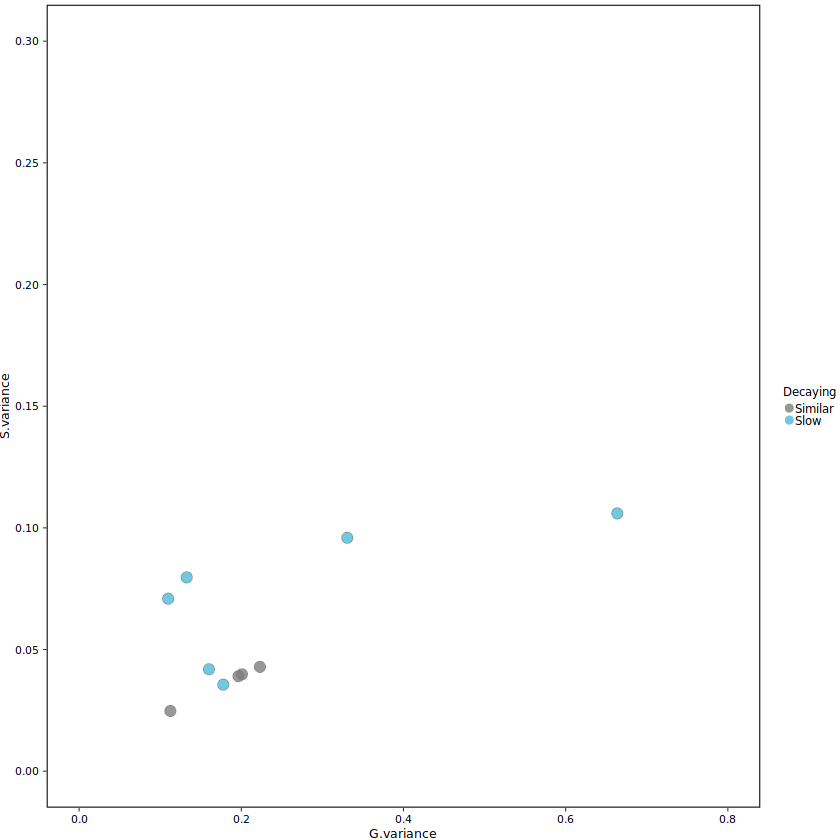

In [57]:
# 함수 사용 예시:
p <- plot_variance(data = for_plot)
print(p)

# # 파일 저장
# output_path <- paste0(
#     "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/", 
#     cohort, 
#     ".prediction.pdf"
# )

# ggsave(
#     filename = output_path,
#     plot = p,
#     width = 103,
#     height = 45.2,
#     units = "mm",
#     dpi = 300
# )

In [33]:
for_plot %>% arrange(desc(Vs_median)) %>% head(3)

,pheno,slope,intercept,significant,Vg_median,Vg_lower,Vg_upper,Vs_median,Vs_lower,Vs_upper,w_median,w_lower,w_upper
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,expected,0.6090383,-0.6313576,slow,0.62059029,0.61737794,0.62436819,0.11880341,0.11735124,0.11994909,0.95,0.95,0.95
2,FVC,0.5058855,-1.5154196,slow,0.31890991,0.31434226,0.32252810,0.08978632,0.08821929,0.09154114,0.95,0.95,0.95
3,max_arm,0.2832635,-2.8427040,slow,0.08707074,0.08442876,0.08993349,0.07588217,0.07477996,0.07698391,0.95,0.95,0.95


In [34]:
for_plot %>% arrange(w_median) %>% head(5)

,pheno,slope,intercept,significant,Vg_median,Vg_lower,Vg_upper,Vs_median,Vs_lower,Vs_upper,w_median,w_lower,w_upper
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Potassium,0.8886585,-1.9557658,similar,0.19755409,0.19355806,0.26733121,0.03848763,0.007085906,0.04176133,0.56,0.45,0.60
2,T_axis,0.5581516,-4.0812027,similar,0.06748695,0.06586653,0.07546834,0.01376570,0.013334788,0.01508011,0.60,0.44,0.60
3,avg_hr,0.5402984,-2.5182775,slow,0.15989191,0.15664733,0.16235598,0.04065011,0.039684413,0.04175886,0.95,0.95,0.95
4,expected,0.6090383,-0.6313576,slow,0.62059029,0.61737794,0.62436819,0.11880341,0.117351242,0.11994909,0.95,0.95,0.95
5,FVC,0.5058855,-1.5154196,slow,0.31890991,0.31434226,0.32252810,0.08978632,0.088219295,0.09154114,0.95,0.95,0.95


In [35]:
for_plot %>%
  mutate(across(where(is.numeric), ~round(., 3))) %>%
  mutate(
    Vg = sprintf("%.3f (%.3f, %.3f)", Vg_median, Vg_lower, Vg_upper),
    Vs = sprintf("%.3f (%.3f, %.3f)", Vs_median, Vs_lower, Vs_upper),
    w = sprintf("%.3f (%.3f, %.3f)", w_median, w_lower, w_upper)
  ) %>%
  select(pheno, significant, Vg, Vs, w) %>%
  filter(pheno %in% c("expected")) %>%
  head()


,pheno,significant,Vg,Vs,w
,<chr>,<chr>,<chr>,<chr>,<chr>
1,expected,slow,"0.621 (0.617, 0.624)","0.119 (0.117, 0.120)","0.950 (0.950, 0.950)"


In [22]:
for_plot %>%
  mutate(across(where(is.numeric), ~round(., 3))) %>%
  mutate(
    Vg = sprintf("%.3f (%.3f, %.3f)", Vg_median, Vg_lower, Vg_upper),
    Vs = sprintf("%.3f (%.3f, %.3f)", Vs_median, Vs_lower, Vs_upper),
    w = sprintf("%.3f (%.3f, %.3f)", w_median, w_lower, w_upper)
  ) %>%
  select(pheno, significant, Vg, Vs, w) %>%
  filter(pheno %in% c("Heel_bone_mineral_density__BMD__T-score,_automated", "Immature_reticulocyte_fraction")) %>%
  head()


,pheno,significant,Vg,Vs,w
,<chr>,<chr>,<chr>,<chr>,<chr>
1,"Heel_bone_mineral_density__BMD__T-score,_automated",fast,"0.140 (0.122, 0.434)","0.221 (0.075, 0.230)","0.450 (0.328, 0.450)"
2,Immature_reticulocyte_fraction,slow,"0.080 (0.066, 0.344)","0.141 (0.011, 0.148)","0.550 (0.550, 0.950)"


In [23]:
for_plot %>%
  mutate(across(where(is.numeric), ~round(., 3))) %>%
  mutate(
    Vg = sprintf("%.3f (%.3f, %.3f)", Vg_median, Vg_lower, Vg_upper),
    Vs = sprintf("%.3f (%.3f, %.3f)", Vs_median, Vs_lower, Vs_upper),
    w = sprintf("%.3f (%.3f, %.3f)", w_median, w_lower, w_upper)
  ) %>%
  select(pheno, significant, Vg, Vs, w) %>%
  filter(pheno %in% c("Alanine_aminotransferase", "Impedance_of_whole_body", "Urate")) %>%
  head()


,pheno,significant,Vg,Vs,w
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Alanine_aminotransferase,fast,"0.185 (0.175, 0.187)","0.033 (0.032, 0.037)","0.010 (0.010, 0.140)"
2,Impedance_of_whole_body,fast,"0.456 (0.455, 0.458)","0.045 (0.044, 0.046)","0.010 (0.010, 0.010)"
3,Urate,fast,"0.368 (0.363, 0.369)","0.037 (0.037, 0.039)","0.010 (0.010, 0.070)"
